<a href="https://colab.research.google.com/github/earendil94/SMLExam/blob/master/SML_Project_Claudia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**STATISTICAL MACHINE LEARNING**

ARRIGHI Leonardo, BRAND Francesco, DORIGO Claudia


Dataset folder is saved in "/content/drive/My Drive/SML/SML_Project".

In [2]:
# link colab and drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
# then follow passages

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
import os
import torchvision
from torchvision import transforms, models
from IPython import display
import shelve
from PIL import Image
import glob

torch.manual_seed(160898)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cuda:0


In [ ]:
# APPLY TRANSFORMATIONS TO PIL IMAGE 
def transform_image(image):
  transform = transforms.Compose([transforms.Resize(256),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                  ])
  return transform(image)

img_prova = Image.open('/content/drive/My Drive/SML/SML_Project/Chunk1/img1_200/1624481.jpg')
transform_image(img_prova)

In [ ]:
# FUNCTION TO BUILD THE DICTIONARY (JUST FIRST 15K IMAGES)
# don't run, it takes 2 hours

def build_img_shelve(img_folder,shelve_path):
  path = os.path.join(img_folder,'*.jpg')
  with shelve.open(shelve_path) as d:
    for i in glob.glob(path)[:15000]: #just first 15000 otherwise too big
      im=Image.open(i)
      d[i[len(img_folder):].split('.')[0]]=transform_image(im)

    
imgs = '/content/drive/My Drive/SML/SML_Project/All_images/'
#build_img_shelve(imgs,'/content/drive/My Drive/SML/SML_Project/img_shelve_15k')

In [36]:
# DICTIONARY FROM SHELVE
def dict_from_shelve(shelve_file):
  dictionary = {}
  d=shelve.open(shelve_file)
  for k in d.keys():
    dictionary[int(k)]=d[k]
  return dictionary

chunk1_dict = dict_from_shelve('/content/drive/My Drive/SML/SML_Project/Chunk1/img_shelve')

In [ ]:
#https://towardsdatascience.com/automatic-image-captioning-with-cnn-rnn-aae3cd442d83
# ENCODER CNN
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1] # remove last layer
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        return features

image = a['10002456']
image = image.unsqueeze(0)
cnn = EncoderCNN()

if torch.cuda.is_available():
  image = image.to('cuda')
  cnn.to('cuda')

output = cnn(image)
print(output,output.shape)

tensor([[0.8236, 0.4843, 0.6832,  ..., 0.4213, 0.3250, 0.4717]],
       device='cuda:0') torch.Size([1, 2048])


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


bow
trench_coat
tank
half_track
stretcher
projectile
bulletproof_vest
rifle
assault_rifle
military_uniform


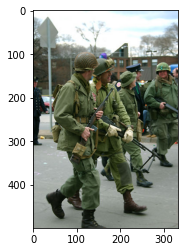

In [11]:
# FUNCTION TO CHECK THE RESULT OF CNN 
#(without removing last layer print 10 more probable classes) 
import json
from matplotlib.pyplot import imshow

def CNN_classification(image,model):
  path = '/content/drive/My Drive/SML/SML_Project/All_images/'
  im = Image.open(os.path.join(path,image+'.jpg'))
  model.eval()

  out = model(transform_image(im).unsqueeze(0))
  #class_probs = torch.nn.functional.softmax(out, dim=0) #not needed

  class_idx = json.load(open("/content/drive/My Drive/SML/SML_Project/classes.json"))
  idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

  # sort wrt probability and take 10 more probable indexes
  for idx in out[0].sort()[1][-10:]:
    print(idx2label[idx])

  #print the image
  %matplotlib inline
  imshow(np.asarray(im))

pretrained_ResNet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
CNN_classification('1624481',pretrained_ResNet)


In [72]:
# DATASET AND SAMPLER CLASSES (FOR DATALOADER)
import torch
from torch.utils.data import Dataset, Sampler, DataLoader
import pandas as pd

class imageCaptionDataset(Dataset):
  '''
    What we want to achieve is a mapping of type:
    { img_name: [img_tensor, caption_1, caption_2, caption_3, caption_4, caption_5]}
  '''

  #TODO: should have a function that puts the two items in the same dictionary
  def __init__(self, preProcessedImages, preProcessedCaptions):
    '''
      This function takes in input two dictionaries and merge them in a big_dictionary
      according to common key values
    '''
    self.big_Dict = {}
    for k in preProcessedCaptions.keys():
      a = preProcessedImages.get(k) # return none if it doesn't exist
      if a is not None:
        self.big_Dict[k] = [a,preProcessedCaptions[k]]

  def __getitem__(self, key):
    '''
      This function returns the preprocessed image and the first preprocessed comment 
      associated with the given key
      TO DO:
      - introduce a function to select the best comment
      - define the behaviour when a key is not present
    '''
    #which_comment = 0 # get first comment - we can add here a function to select the best
    comments = self.big_Dict[key][1]
    returned_comment = comments.get('Caption_1')
    return self.big_Dict[key][0], returned_comment, returned_comment.size()

  def get_keys(self):
    '''
      I need this function in the sampler. It returns a list with all the 
      keys present in the big dictionary
    '''
    return self.big_Dict.keys()


class imageCaptionSampler(Sampler):
  '''
    TO DO: 
    - _iter_ which returns an iterable over the dataset
    - _len_ which returns the length of the dataset (needed to compute number of batches in dataloader)
  '''
  def __init__(self, data_source):
    self.data_source = data_source

  def __iter__(self):
    '''
      we don't care the order in which iterate the dataset so this function defines
      an iterator over the key list
    '''
    return iter(self.data_source.get_keys())

  def __len__(self):
    return len(self.data_source.get_keys())  


In [ ]:
# CAPTION PREPROCESSING FUNCTIONS
from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.data import Iterator

def prepare_data(path, input_file, output_file):
  input_path = os.path.join(path, input_file)
  output_path = os.path.join(path, output_file)
  df = pd.read_csv(input_path, sep = "|")
  captions_array = df[' comment']
  captions_array.fillna("", inplace=True)
  
  image_names = df["image_name"].values
  image_number = []
  for i in range(0, len(image_names)):
    image_number.append(image_names[i].split('.')[0])

  df.drop(labels=['image_name', ' comment_number'], axis=1, inplace=True)
  df.index = image_number
  df.to_csv(output_path, index_label="image_number")
  return output_path

def build_vocab(path_to_caption_file, caption_file):
  output_path = prepare_data(path_to_caption_file, caption_file, "clean.csv")
  tokenize = lambda x : x.split()
  TEXT = Field(sequential = True, tokenize = tokenize, lower=True, init_token='<start>', eos_token='<end>')
  LABEL = Field(sequential=False, use_vocab=False)
  td_datafields = [("image_number", LABEL ),
                  ("comment", TEXT)]

  trn = TabularDataset(
              path=output_path, # the root directory where the data lies
              format='csv',
              skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
              fields=td_datafields,
              )
  
  TEXT.build_vocab(trn)
  return TEXT.vocab

def word_caption_to_index(path_to_caption_file, caption_file):
  '''
    This function takes as input the file containing the captions
    and returns a matrix of the captions indexed with respect to the inner
    vocabulary, as well as an array that can be used to map the indexed caption
    to the image it belongs to.
    @path_to_caption_file: the path to file containing the captions
    @caption_file: the name of the file containing the captions
  '''

  output_path = prepare_data(path_to_caption_file, caption_file, "clean.csv")
  tokenize = lambda x : x.split()
  TEXT = Field(sequential = True, tokenize = tokenize, lower=True, init_token='<start>', eos_token='<end>')
  LABEL = Field(sequential=False, use_vocab=False)

  td_datafields = [("image_number", LABEL ),
                  ("comment", TEXT)]

  trn = TabularDataset(
                path=output_path, # the root directory where the data lies
                format='csv',
                skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
                fields=td_datafields
                )
  
  TEXT.build_vocab(trn)
  train_iter = Iterator(trn, batch_size=len(trn), device = -1)

  for i in train_iter: #TODO:I really havent got it how this still works honestly
    cmt = i.comment
    img = i.image_number

  return cmt.T, img

def vocab_as_dict(path_to_caption_file, caption_file):
  vocab = build_vocab(path_to_caption_file, caption_file)
  return vocab.stoi

def tensor_to_word(indexed_word, vocab):
  for i in indexed_word:
    k = i.item()
    if k == 1:
      break
    else:
      print(vocab.itos[k], end = " ")
    
  

def get_caption_from_image(caption_indexes, caption_refs, image_number):
  #If image name actually has the .jpg tail
  caption_refs = (caption_refs == int(image_number))
  caption_refs = caption_refs.nonzero().T.numpy()[0].tolist()
  return caption_indexes[caption_refs]

def buildCaptionDict(path_to_caption_file, caption_file):

  caption_index, refs = word_caption_to_index(path_to_caption_file, caption_file)
  refs_list = refs.numpy().tolist()
  refs_set = set(refs_list)
  unique_refs_list = list(refs_set)

  df = []
  df = pd.DataFrame(columns=["Image_number", "Caption_1", "Caption_2", "Caption_3", "Caption_4", "Caption_5"])

  for i in range(0, len(unique_refs_list)):
    capt_1 = get_caption_from_image(caption_index, refs, unique_refs_list[i])[0]
    capt_2 = get_caption_from_image(caption_index, refs, unique_refs_list[i])[1]
    capt_3 = get_caption_from_image(caption_index, refs, unique_refs_list[i])[2]
    capt_4 = get_caption_from_image(caption_index, refs, unique_refs_list[i])[3]
    capt_5 = get_caption_from_image(caption_index, refs, unique_refs_list[i])[4]
    df.loc[i] = [unique_refs_list[i], capt_1, capt_2, capt_3, capt_4, capt_5]

  df.set_index('Image_number', inplace=True)
  capt_dict = df.to_dict('index')

  return capt_dict

In [77]:
# TEST ON OUR DATA
# image dictionary
chunk1_dict = dict_from_shelve('/content/drive/My Drive/SML/SML_Project/Chunk1/img_shelve')

# caption dictionary
path_to_caption_file = "/content/drive/My Drive/SML/SML_Project/Chunk1"
caption_file = "results.csv"
caption_dict = buildCaptionDict(path_to_caption_file, caption_file)



The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [83]:
dataset = imageCaptionDataset(chunk1_dict,caption_dict)
#chunk1_dict['1624481']
img_tensor, caption_tensor, size = dataset[1624481]
print(img_tensor)
print(caption_tensor)
print(size)
dataset.get_keys()

tensor([[[-0.7822, -0.6794, -0.6109,  ...,  0.2453,  0.4508,  0.8276],
         [-0.8678, -0.8507, -0.8678,  ..., -0.6794, -0.5596, -0.4226],
         [-0.8849, -0.8507, -0.8507,  ..., -0.7479, -0.7308, -0.7650],
         ...,
         [ 0.8447,  0.8447,  0.8276,  ...,  0.3309,  0.3481,  0.3481],
         [ 0.9303,  0.9474,  0.9303,  ...,  0.3652,  0.3652,  0.3652],
         [ 0.9132,  0.9303,  0.9303,  ...,  0.4166,  0.3823,  0.3652]],

        [[-0.6352, -0.4951, -0.3901,  ...,  0.4678,  0.6779,  1.0455],
         [-0.7227, -0.6702, -0.6527,  ..., -0.5476, -0.4251, -0.2675],
         [-0.7402, -0.6702, -0.6527,  ..., -0.7402, -0.7227, -0.7227],
         ...,
         [ 1.0980,  1.0980,  1.0805,  ...,  0.5728,  0.5903,  0.5903],
         [ 1.1856,  1.2031,  1.1856,  ...,  0.6078,  0.6078,  0.6078],
         [ 1.1681,  1.1856,  1.1856,  ...,  0.6604,  0.6254,  0.6078]],

        [[-0.6367, -0.5321, -0.4798,  ...,  0.2522,  0.4614,  0.8622],
         [-0.7064, -0.7064, -0.6890,  ..., -0

dict_keys([7340189, 134206, 5377361, 5771732, 4985704, 4199555, 1317156, 793558, 2760167, 10101477, 3680138, 3025093, 6827028, 6696219, 5648321, 667626, 8664920, 8664922, 3160699, 5914327, 8404753, 5521996, 148284, 9324151, 675153, 3035057, 5918675, 5918840, 807129, 5919020, 5526034, 1989609, 5791070, 5791244, 5791568, 6054169, 5400154, 9726060, 5402085, 3043766, 8680922, 4749855, 2784746, 9600569, 4489731, 8684718, 8029536, 2656351, 36979, 301246, 7510394, 6331511, 10002456, 960092, 6335241, 5287405, 438106, 178045, 6338704, 6338733, 6339096, 10010052, 10404007, 7520721, 7520731, 6734417, 574181, 4376178, 8832804, 1624481, 2148982, 4378823, 5558592, 2806447, 6214447, 7656601, 8443156, 7527111, 4906946, 2285664, 1369162, 4515460, 5958182, 4386588, 5566972, 10287332, 1243756, 3996401, 3734864, 5570219, 5570254, 65567, 8454235, 7013217, 984950, 8063007, 8849890, 2689611, 7015055, 854749, 10160966, 9637989, 5444724, 6100315, 726414, 4135695, 3219606, 205842, 7808046, 1254659, 4926723, 885

In [90]:
# initialize a sampler
sampler = imageCaptionSampler(dataset)

# initialize a dataloader using these 2 new classes
dataloader = DataLoader(dataset, batch_size=10, sampler=sampler,num_workers=1)

# check if iteration works
dataiter = iter(dataloader)
print(dataiter.next())
#print(dataiter.next()) 

len(dataloader)

[tensor([[[[ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
          [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
          [ 2.2147,  2.2147,  2.2147,  ...,  2.2147,  2.2147,  2.2147],
          ...,
          [ 0.7591,  0.9303,  0.6221,  ...,  0.0227,  0.0056, -0.0972],
          [ 1.1187,  0.8276,  0.9303,  ..., -0.2856, -0.1143, -0.0116],
          [ 0.5536,  0.5878,  0.5364,  ...,  0.0569,  0.0912,  0.3652]],

         [[ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
          [ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
          [ 2.3936,  2.3936,  2.3936,  ...,  2.3936,  2.3936,  2.3936],
          ...,
          [ 0.9580,  1.1331,  0.7829,  ...,  0.0651,  0.0651, -0.0049],
          [ 1.3431,  1.0455,  1.0980,  ..., -0.2850, -0.1099,  0.0651],
          [ 0.7829,  0.8004,  0.7129,  ...,  0.0651,  0.1001,  0.3978]],

         [[ 2.6051,  2.6051,  2.6051,  ...,  2.6051,  2.6051,  2.6051],
          [ 2.6051,  2.6051, 

20